In [127]:
import pyodbc
import copy

import pandas as pd
import numpy as np
import re



import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score

### DB Connections

In [2]:
server = 'saab-server-resource.database.windows.net'
database = 'SAAB_DW_Resource'
username = 'saabadmin'
password = 'p@$$w0rd'
cnxn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

### Reading Data

In [3]:
data = pd.read_sql_query("select * from [dbo].[Fact_Audio_Insights] order by [Call_ID],[StartTime];",cnxn)
# Uncomment below if reading manual transcripts from excel file
# data = pd.read_excel("C://Users//mhanagodu//OneDrive - DXC Production//Project//Speech_Analytics_Asset_Building//Files//EnglishManualTranscriptDF.xlsx",sheet_name="Sheet3")

In [4]:
distict_call_ids = list(data['Call_ID'].unique())

### Key Phrases Dictionary Approach

In [5]:
introduction_section = ["how may I help","welcome to","thank you for calling","i am calling from","i can help you","i can assist you with"]
mid_section = ["for verification purpose","I can help you","I will help you","i can assist you with","apologize for","for the inconvenience"]
closure_section = ["thank you for calling","have a pleasant day","have a nice day","i will transfer the call","is there anything else","i can assist you with"]

##### Function to get the Speaker IDs which matches the agent script

In [6]:
def get_speaker_list(sentences_list,keyphrase_list,temp_data):
    indexes_list = []
    speaker_list = []
    for phrase in keyphrase_list:
        indexes_list = [sentences_list.index(x) if phrase in x else '' for x in sentences_list]
        for i in indexes_list:
            if (isinstance(i,int)):
                speaker_list.append(temp_data.loc[i,'SpeakerId'])      
    return speaker_list

##### Identifying speaker ids for different sections

In [11]:
call_id_agent_mapping_dict = {}
for call_id in distict_call_ids:
    
    temp_data = data[data['Call_ID']==call_id][['Call_ID','SpeakerId','StartTime','Display']]
#     print(len(temp_datap_data))
    # Uncomment below if reading manual transcripts from excel file
#     temp_data = data[data['Call_ID']==call_id].reset_index(drop=True)

    # Introduction section check for agent spoken phrases
    intro_speaker_list = get_speaker_list(list(temp_data['Display'][:5]),introduction_section,temp_data)   
    
    # Mid section check for agent spoken phrases
    mid_speaker_list = get_speaker_list(list(temp_data['Display'][5:-5]),mid_section,temp_data)
    
    # Closure section check for agent spoken phrases
    closure_speaker_list = get_speaker_list(list(temp_data['Display'][-5:]),closure_section,temp_data)
    
    # Adding all the most occcuring Speaker IDs from diffent sections into a final list
    final_spk_list = []
    if intro_speaker_list:
        final_spk_list.append(max(intro_speaker_list,key=intro_speaker_list.count))
    if mid_speaker_list:
        final_spk_list.append(max(mid_speaker_list,key=mid_speaker_list.count))
    if closure_speaker_list:
        final_spk_list.append(max(closure_speaker_list,key=closure_speaker_list.count))
    
    # Creating a dictionary containing the SpeakerID flagged as agent
    if final_spk_list:
        call_id_agent_mapping_dict[call_id] = max(final_spk_list,key=final_spk_list.count)
    else:
        call_id_agent_mapping_dict[call_id] = np.nan
#     break
# call_id_agent_mapping_dict

In [ ]:
manual_labelled_df = pd.DataFrame.from_dict(call_id_agent_mapping_dict, orient='index',columns=['Agent_ID']).reset_index().rename(columns={'index':'Call_ID'})

In [ ]:
manual_labelled_df.head()

In [ ]:
# Number of missed transcripts
manual_labelled_df.head()

### Classification approach - on manual transcripts

In [134]:
manual_trasncript_data = pd.read_excel("C://Users//mhanagodu//OneDrive - DXC Production//Project//Speech_Analytics_Asset_Building//Files//EnglishManualTranscriptDF.xlsx",sheet_name="Sheet3")

In [135]:
# manual_trasncript_data = manual_trasncript_data[['SpeakerId','Display']]
manual_trasncript_data.head()

,Call_ID,SpeakerId,Display
0,1-Agent4-2-INC wav,A,hello sir good morning this is alexa how may ...
1,1-Agent4-2-INC wav,C,hi my name is sky i wanted to take a term insu...
2,1-Agent4-2-INC wav,A,sure madam term insurance is the life insuranc...
3,1-Agent4-2-INC wav,C,Alright and how much is the premium and how m...
4,1-Agent4-2-INC wav,A,that benefit will depend on the type of the po...


##### Quality Check
###### Replacing a lowercase labels to an uppercase label

In [136]:
# Quality check 
manual_trasncript_data['SpeakerId'].value_counts()
# Replacing a lowercase labels to an uppercase label
manual_trasncript_data.loc[manual_trasncript_data[manual_trasncript_data['SpeakerId']=="c"].index[0],'SpeakerId'] = 'C'

###### Preprocessing text

In [147]:
# Preprocessing text
lemmatized_text = []
count = 0
for row in manual_trasncript_data.itertuples():
    # Removing extra spaces, special characters and punctuation marks and lower casing the text
    clean_text = re.sub(r'\s\s+',r' ',re.sub(r'[?|$|.|!|#|%|^|*|:|;|,|+|-|_|=|&]',r'',row[3].lower()))
    # Lemmatizing the text
    lemmatized_text.append(" ".join([str(token.lemma_).replace('-PRON-',str(token)) for token in nlp(str(clean_text))]))    

In [148]:
manual_trasncript_data['Lemmatized_Text'] = lemmatized_text

In [198]:
manual_trasncript_data.head(15)

,Call_ID,SpeakerId,Display,Lemmatized_Text
0,1-Agent4-2-INC wav,A,hello sir good morning this is alexa how may ...,hello sir good morning this be alexa how may i...
1,1-Agent4-2-INC wav,C,hi my name is sky i wanted to take a term insu...,hi my name be sky i want to take a term insura...
2,1-Agent4-2-INC wav,A,sure madam term insurance is the life insuranc...,sure madam term insurance be the life insuranc...
3,1-Agent4-2-INC wav,C,Alright and how much is the premium and how m...,alright and how much be the premium and how mu...
4,1-Agent4-2-INC wav,A,that benefit will depend on the type of the po...,that benefit will depend on the type of the po...
5,1-Agent4-2-INC wav,C,okay and one more thing you told me the best b...,okay and one more thing you tell me the good b...
6,1-Agent4-2-INC wav,A,that will be given from the insurance company ...,that will be give from the insurance company t...
7,1-Agent4-2-INC wav,C,And also can i apply for this online,and also can i apply for this online
8,1-Agent4-2-INC wav,A,yeah you can apply online also,yeah you can apply online also
9,1-Agent4-2-INC wav,C,alright fine thank you so much,alright fine thank you so much


##### Stratified Sampling

In [150]:
# xTrain, xTest, yTrain, yTest = train_test_split(manual_trasncript_data['Lemmatized_Text'], manual_trasncript_data['SpeakerId'], test_size = 0.2, random_state = 0)
X = manual_trasncript_data['Lemmatized_Text']
y = manual_trasncript_data['SpeakerId']
sss = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=32)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [151]:
X_train

238     hi i wanna know how do i check my fund value o...
85      good morning hdfc life my name be alexa how ma...
315                                             yeah sure
422     i be sorry madam can i have your name and poli...
122         sir you could just mention your policy number
                              ...                        
768     yeah my name be john and i want to know about ...
570     good afternoon hdfc life customer care this be...
1002    i be keira and my number be four two four one ...
883     you can get in them online also you can get in...
634     my phone number be eight seven one five six se...
Name: Lemmatized_Text, Length: 809, dtype: object

##### Stratified sampling on Train set

In [152]:
# # Stratified sampling on Train set
# X_tra = pd.DataFrame(X_train.reset_index())['Lemmatized_Text']
# y_tra = pd.DataFrame(y_train.reset_index())['SpeakerId']
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
# sss.get_n_splits(X_tra, y_tra)
# for train_index, test_index in sss.split(X_tra, y_tra):
#     X_train_dev, X_test_val = X_tra[train_index], X_tra[test_index]
#     y_train_dev, y_test_val = y_tra[train_index], y_tra[test_index]

In [153]:
# Feature Selection
# Create dummies for classes
y_train_dummies = pd.get_dummies(y_train)

In [154]:
# Convert to token counts
count_vec = CountVectorizer(ngram_range=(2,3),binary=True)
# count_vec = CountVectorizer(binary=True)
X_train_count = count_vec.fit_transform(X_train)
transformer = TfidfTransformer()
X_train_transformed = transformer.fit_transform(X_train_count)

In [155]:
X_train_transformed

<809x11849 sparse matrix of type '<class 'numpy.float64'>'
	with 23323 stored elements in Compressed Sparse Row format>

In [98]:
# print(list(y_train_dummies.columns))
# chi2(X_train_count, y_train_dummies['A'])[0]

##### Select best feature using chi2 to exclude  less weightage feature

In [156]:
# Hyperparameters
no_of_features = 1000
chi_square_threshold = 1

In [157]:
# Select best feature using chi2 to exclude  less weightage feature

columns = list(y_train_dummies.columns)
features_final=[]
chi_probability = []
for col in columns:
    chi_score = chi2(X_train_transformed, y_train_dummies[col])[0]
    chi_prob = chi2(X_train_transformed, y_train_dummies[col])[1]
    features = count_vec.get_feature_names()
    chi_table = pd.DataFrame({'Features':features, 'Chisquare':chi_score , 'Chi_Square_Prob':chi_prob})
    chi_table_cutoff = chi_table.loc[(chi_table["Chisquare"] > chi_square_threshold)] 
    if len(chi_table_cutoff)>no_of_features:
        chi_table = chi_table_cutoff.sort_values(by='Chisquare', ascending=False).head(no_of_features)
    else:
        chi_table = chi_table_cutoff
    features_final.append(chi_table['Features'].tolist())
    chi_probability.append(chi_table['Chisquare'].tolist())
features_all = [item for sublist in features_final for item in sublist]
chi_values_all = [item for sublist in chi_probability for item in sublist]
features_all_table = pd.DataFrame({'Features':features_all , 'Chisquare':chi_values_all})
features_best_chi = pd.DataFrame(features_all_table.groupby(['Features'], as_index=False, sort=False)['Chisquare'].max())
features_best_chi

,Features,Chisquare
0,afternoon hdfc,3.448622
1,afternoon hdfc life,3.448622
2,afternoon welcome,2.684671
3,afternoon welcome to,2.684671
4,alex how,3.753863
...,...,...
320,your full name,2.630036
321,your name,4.468248
322,your name and,3.904318
323,your policy,2.331867


In [158]:
# Finding best k features on set 2
k_val = features_best_chi.shape[0]
scores_f1 = []
for k in range(1, int(k_val), 1):
    features_table = features_best_chi.sort_values('Chisquare', ascending=False).head(k)
#     print()
#     print(features_table)
#     print("**********************************")
    # Bi gram
    model = Pipeline([('vect', CountVectorizer(vocabulary=features_table.Features,ngram_range=(2,3))),
                     ('tfidf', TfidfTransformer()),
                     ('clf',  CalibratedClassifierCV(LinearSVC(penalty="l2", dual=False, tol=1e-3),cv=KFold(n_splits=3))),])#LinearSVC(penalty="l2", dual=False,tol=1e-3)
    # Training the Model
    model.fit(X_train, y_train)
    # Scoring the Model
    predicted = model.predict(X_test)
    scores_f1.append(f1_score(y_test, predicted, average='weighted'))

kvals_list = list(range(1,int(k_val),1))

scores_f1_table = pd.DataFrame({'K_values':kvals_list, 'F1-Score':scores_f1})
kval_top = scores_f1_table.sort_values(by='F1-Score', ascending=False).head(n=10)
kval_optimum = int(kval_top.iloc[0,0])
kval_optimum

     Features  Chisquare
110  help you  11.076875
**********************************
     Features  Chisquare
110  help you  11.076875
148  may help   8.276933
**********************************
         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help you   8.276933
**********************************
         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help you   8.276933
118       how may   8.276933
**********************************
         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help you   8.276933
118       how may   8.276933
119  how may help   8.276933
**********************************
         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help you   8.276933
118       how may   8.276933
119  how may help   8.276933
102     hdfc life   7.553988
**********************************
         Features  Chisquar

             Features  Chisquare
110          help you  11.076875
148          may help   8.276933
149      may help you   8.276933
118           how may   8.276933
119      how may help   8.276933
102         hdfc life   7.553988
187         number be   6.769772
276           to hdfc   5.742657
290   welcome to hdfc   5.675189
289        welcome to   5.675189
170          name and   5.672384
223  policy number be   5.451407
166         my policy   5.231831
12             and my   5.169602
277      to hdfc life   4.916465
127         know your   4.566591
167  my policy number   4.560978
316          you with   4.508104
321         your name   4.468248
92     good afternoon   4.264769
179           no that   4.214999
205         okay sure   4.207479
264    there anything   4.121205
**********************************
              Features  Chisquare
110           help you  11.076875
148           may help   8.276933
149       may help you   8.276933
118            how may   8.276933
119

              Features  Chisquare
110           help you  11.076875
148           may help   8.276933
149       may help you   8.276933
118            how may   8.276933
119       how may help   8.276933
102          hdfc life   7.553988
187          number be   6.769772
276            to hdfc   5.742657
290    welcome to hdfc   5.675189
289         welcome to   5.675189
170           name and   5.672384
223   policy number be   5.451407
166          my policy   5.231831
12              and my   5.169602
277       to hdfc life   4.916465
127          know your   4.566591
167   my policy number   4.560978
316           you with   4.508104
321          your name   4.468248
92      good afternoon   4.264769
179            no that   4.214999
205          okay sure   4.207479
264     there anything   4.121205
51   be there anything   4.121205
62        can help you   4.118097
291            what be   4.107215
61            can help   4.011168
322      your name and   3.904318
180         no

                Features  Chisquare
110             help you  11.076875
148             may help   8.276933
149         may help you   8.276933
118              how may   8.276933
119         how may help   8.276933
102            hdfc life   7.553988
187            number be   6.769772
276              to hdfc   5.742657
290      welcome to hdfc   5.675189
289           welcome to   5.675189
170             name and   5.672384
223     policy number be   5.451407
166            my policy   5.231831
12                and my   5.169602
277         to hdfc life   4.916465
127            know your   4.566591
167     my policy number   4.560978
316             you with   4.508104
321            your name   4.468248
92        good afternoon   4.264769
179              no that   4.214999
205            okay sure   4.207479
264       there anything   4.121205
51     be there anything   4.121205
62          can help you   4.118097
291              what be   4.107215
61              can help   4

                Features  Chisquare
110             help you  11.076875
148             may help   8.276933
149         may help you   8.276933
118              how may   8.276933
119         how may help   8.276933
102            hdfc life   7.553988
187            number be   6.769772
276              to hdfc   5.742657
290      welcome to hdfc   5.675189
289           welcome to   5.675189
170             name and   5.672384
223     policy number be   5.451407
166            my policy   5.231831
12                and my   5.169602
277         to hdfc life   4.916465
127            know your   4.566591
167     my policy number   4.560978
316             you with   4.508104
321            your name   4.468248
92        good afternoon   4.264769
179              no that   4.214999
205            okay sure   4.207479
264       there anything   4.121205
51     be there anything   4.121205
62          can help you   4.118097
291              what be   4.107215
61              can help   4

                Features  Chisquare
110             help you  11.076875
148             may help   8.276933
149         may help you   8.276933
118              how may   8.276933
119         how may help   8.276933
102            hdfc life   7.553988
187            number be   6.769772
276              to hdfc   5.742657
290      welcome to hdfc   5.675189
289           welcome to   5.675189
170             name and   5.672384
223     policy number be   5.451407
166            my policy   5.231831
12                and my   5.169602
277         to hdfc life   4.916465
127            know your   4.566591
167     my policy number   4.560978
316             you with   4.508104
321            your name   4.468248
92        good afternoon   4.264769
179              no that   4.214999
205            okay sure   4.207479
264       there anything   4.121205
51     be there anything   4.121205
62          can help you   4.118097
291              what be   4.107215
61              can help   4

                Features  Chisquare
110             help you  11.076875
148             may help   8.276933
149         may help you   8.276933
118              how may   8.276933
119         how may help   8.276933
102            hdfc life   7.553988
187            number be   6.769772
276              to hdfc   5.742657
290      welcome to hdfc   5.675189
289           welcome to   5.675189
170             name and   5.672384
223     policy number be   5.451407
166            my policy   5.231831
12                and my   5.169602
277         to hdfc life   4.916465
127            know your   4.566591
167     my policy number   4.560978
316             you with   4.508104
321            your name   4.468248
92        good afternoon   4.264769
179              no that   4.214999
205            okay sure   4.207479
264       there anything   4.121205
51     be there anything   4.121205
62          can help you   4.118097
291              what be   4.107215
61              can help   4

               Features  Chisquare
110            help you  11.076875
148            may help   8.276933
149        may help you   8.276933
118             how may   8.276933
119        how may help   8.276933
..                  ...        ...
139        life my name   2.739258
138             life my   2.739258
151       may know your   2.733183
324  your policy number   2.708674
248          sure madam   2.695300

[70 rows x 2 columns]
**********************************
                   Features  Chisquare
110                help you  11.076875
148                may help   8.276933
149            may help you   8.276933
118                 how may   8.276933
119            how may help   8.276933
..                      ...        ...
138                 life my   2.739258
151           may know your   2.733183
324      your policy number   2.708674
248              sure madam   2.695300
94   good afternoon welcome   2.684671

[71 rows x 2 columns]
*******************************

                     Features  Chisquare
110                  help you  11.076875
148                  may help   8.276933
149              may help you   8.276933
118                   how may   8.276933
119              how may help   8.276933
..                        ...        ...
59                   can have   2.546341
84           for verification   2.494519
85   for verification purpose   2.494519
237           six seven eight   2.478304
251             thank you for   2.465948

[88 rows x 2 columns]
**********************************
                     Features  Chisquare
110                  help you  11.076875
148                  may help   8.276933
149              may help you   8.276933
118                   how may   8.276933
119              how may help   8.276933
..                        ...        ...
84           for verification   2.494519
85   for verification purpose   2.494519
237           six seven eight   2.478304
251             thank you for   2.465948

           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         how may   8.276933
119    how may help   8.276933
..              ...        ...
306         you for   2.344979
323     your policy   2.331867
101  have your name   2.330634
270         this be   2.317814
74         else can   2.274132

[106 rows x 2 columns]
**********************************
           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         how may   8.276933
119    how may help   8.276933
..              ...        ...
323     your policy   2.331867
101  have your name   2.330634
270         this be   2.317814
74         else can   2.274132
72       eight nine   2.256200

[107 rows x 2 columns]
**********************************
                Features  Chisquare
110             help you  11.076875
148             may help   8.276933
149         may help you   8.2

                 Features  Chisquare
110              help you  11.076875
148              may help   8.276933
149          may help you   8.276933
118               how may   8.276933
119          how may help   8.276933
..                    ...        ...
136        life insurance   1.967088
27   around twelve thirty   1.962178
174         name be angel   1.961155
38                be four   1.955252
39           be four five   1.933438

[123 rows x 2 columns]
**********************************
                 Features  Chisquare
110              help you  11.076875
148              may help   8.276933
149          may help you   8.276933
118               how may   8.276933
119          how may help   8.276933
..                    ...        ...
27   around twelve thirty   1.962178
174         name be angel   1.961155
38                be four   1.955252
39           be four five   1.933438
76              else that   1.920325

[124 rows x 2 columns]
*****************************

           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         how may   8.276933
119    how may help   8.276933
..              ...        ...
13    and my mobile   1.884971
32          be alex   1.880437
211   one two three   1.872702
190  number be four   1.849871
82         for that   1.849226

[143 rows x 2 columns]
**********************************
           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         how may   8.276933
119    how may help   8.276933
..              ...        ...
32          be alex   1.880437
211   one two three   1.872702
190  number be four   1.849871
82         for that   1.849226
300    yeah my name   1.842481

[144 rows x 2 columns]
**********************************
           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         ho

            Features  Chisquare
110         help you  11.076875
148         may help   8.276933
149     may help you   8.276933
118          how may   8.276933
119     how may help   8.276933
..               ...        ...
266         think no   1.741299
104   hdfc life have   1.734359
132        life have   1.734359
287          want to   1.730939
31   assist you with   1.722395

[162 rows x 2 columns]
**********************************
            Features  Chisquare
110         help you  11.076875
148         may help   8.276933
149     may help you   8.276933
118          how may   8.276933
119     how may help   8.276933
..               ...        ...
104   hdfc life have   1.734359
132        life have   1.734359
287          want to   1.730939
31   assist you with   1.722395
30        assist you   1.722395

[163 rows x 2 columns]
**********************************
            Features  Chisquare
110         help you  11.076875
148         may help   8.276933
149     may help y

          Features  Chisquare
110       help you  11.076875
148       may help   8.276933
149   may help you   8.276933
118        how may   8.276933
119   how may help   8.276933
..             ...        ...
176       nine one   1.690632
314    you want to   1.671125
105  hdfc life how   1.670880
134       life how   1.670880
227   really sorry   1.660759

[180 rows x 2 columns]
**********************************
          Features  Chisquare
110       help you  11.076875
148       may help   8.276933
149   may help you   8.276933
118        how may   8.276933
119   how may help   8.276933
..             ...        ...
314    you want to   1.671125
105  hdfc life how   1.670880
134       life how   1.670880
227   really sorry   1.660759
311       you need   1.660636

[181 rows x 2 columns]
**********************************
          Features  Chisquare
110       help you  11.076875
148       may help   8.276933
149   may help you   8.276933
118        how may   8.276933
119   how ma

               Features  Chisquare
110            help you  11.076875
148            may help   8.276933
149        may help you   8.276933
118             how may   8.276933
119        how may help   8.276933
..                  ...        ...
203       okay madam so   1.565299
317          young star   1.564029
194       number please   1.563736
69               do not   1.561824
226  purpose may please   1.553144

[200 rows x 2 columns]
**********************************
               Features  Chisquare
110            help you  11.076875
148            may help   8.276933
149        may help you   8.276933
118             how may   8.276933
119        how may help   8.276933
..                  ...        ...
317          young star   1.564029
194       number please   1.563736
69               do not   1.561824
226  purpose may please   1.553144
143      madam be there   1.552460

[201 rows x 2 columns]
**********************************
               Features  Chisquare
110    

             Features  Chisquare
110          help you  11.076875
148          may help   8.276933
149      may help you   8.276933
118           how may   8.276933
119      how may help   8.276933
..                ...        ...
109           help me   1.450789
115            how be   1.450110
278       to know how   1.444250
186      nothing else   1.440749
146  madam please can   1.438347

[219 rows x 2 columns]
**********************************
             Features  Chisquare
110          help you  11.076875
148          may help   8.276933
149      may help you   8.276933
118           how may   8.276933
119      how may help   8.276933
..                ...        ...
115            how be   1.450110
278       to know how   1.444250
186      nothing else   1.440749
146  madam please can   1.438347
164        my name be   1.430562

[220 rows x 2 columns]
**********************************
             Features  Chisquare
110          help you  11.076875
148          may help   

            Features  Chisquare
110         help you  11.076875
148         may help   8.276933
149     may help you   8.276933
118          how may   8.276933
119     how may help   8.276933
..               ...        ...
36          be eight   1.347961
188  number be eight   1.347961
125         know how   1.343347
157          me your   1.340399
250     tell me your   1.340399

[239 rows x 2 columns]
**********************************
            Features  Chisquare
110         help you  11.076875
148         may help   8.276933
149     may help you   8.276933
118          how may   8.276933
119     how may help   8.276933
..               ...        ...
188  number be eight   1.347961
125         know how   1.343347
157          me your   1.340399
250     tell me your   1.340399
159    moment please   1.339184

[240 rows x 2 columns]
**********************************
             Features  Chisquare
110          help you  11.076875
148          may help   8.276933
149      may he

         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help you   8.276933
118       how may   8.276933
119  how may help   8.276933
..            ...        ...
181        not an   1.285962
182  not an issue   1.285962
8        an issue   1.285962
303      yes need   1.284341
175   need online   1.284341

[257 rows x 2 columns]
**********************************
            Features  Chisquare
110         help you  11.076875
148         may help   8.276933
149     may help you   8.276933
118          how may   8.276933
119     how may help   8.276933
..               ...        ...
182     not an issue   1.285962
8           an issue   1.285962
303         yes need   1.284341
175      need online   1.284341
304  yes need online   1.284341

[258 rows x 2 columns]
**********************************
               Features  Chisquare
110            help you  11.076875
148            may help   8.276933
149        may help you   8.276933
118       

              Features  Chisquare
110           help you  11.076875
148           may help   8.276933
149       may help you   8.276933
118            how may   8.276933
119       how may help   8.276933
..                 ...        ...
214  pension plus plan   1.158802
209     one more thing   1.150058
160         more thing   1.150058
232            sir for   1.149742
195         number sir   1.135588

[276 rows x 2 columns]
**********************************
           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         how may   8.276933
119    how may help   8.276933
..              ...        ...
209  one more thing   1.150058
160      more thing   1.150058
232         sir for   1.149742
195      number sir   1.135588
19      and want to   1.133744

[277 rows x 2 columns]
**********************************
         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help y

           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         how may   8.276933
119    how may help   8.276933
..              ...        ...
53     be wonderful   1.081918
208           on my   1.079403
9           and how   1.078798
240          so you   1.078004
126  know what time   1.074976

[295 rows x 2 columns]
**********************************
           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         how may   8.276933
119    how may help   8.276933
..              ...        ...
208           on my   1.079403
9           and how   1.078798
240          so you   1.078004
126  know what time   1.074976
288    want to know   1.074250

[296 rows x 2 columns]
**********************************
           Features  Chisquare
110        help you  11.076875
148        may help   8.276933
149    may help you   8.276933
118         ho

         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help you   8.276933
118       how may   8.276933
119  how may help   8.276933
..            ...        ...
296    will check   1.028377
43      be really   1.024447
46        be that   1.023942
64        can you   1.023748
20      angel and   1.018697

[315 rows x 2 columns]
**********************************
         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help you   8.276933
118       how may   8.276933
119  how may help   8.276933
..            ...        ...
43      be really   1.024447
46        be that   1.023942
64        can you   1.023748
20      angel and   1.018697
35   be angel and   1.018697

[316 rows x 2 columns]
**********************************
         Features  Chisquare
110      help you  11.076875
148      may help   8.276933
149  may help you   8.276933
118       how may   8.276933
119  how may help   8.276933
..          

283

In [159]:
scores_f1_table

,K_values,F1-Score
0,1,0.546227
1,2,0.546227
2,3,0.546227
3,4,0.553694
4,5,0.553694
...,...,...
319,320,0.866801
320,321,0.866801
321,322,0.866801
322,323,0.866801


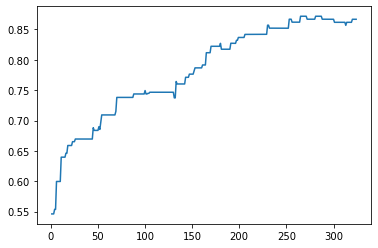

In [160]:
import matplotlib.pyplot as plt
plt.plot(scores_f1_table['K_values'], scores_f1_table['F1-Score'])
plt.show()

##### Training data with optimal features

In [161]:
features_table_chi_top.Features

110                 help you
148                 may help
149             may help you
118                  how may
119             how may help
               ...          
267                 think so
183             not think so
95              good morning
40                  be kevin
260    the inconvenience sir
Name: Features, Length: 283, dtype: object

In [162]:
len(features_best_chi.Features)

325

In [163]:
# Training data with optimal features
features_table_chi_top = features_best_chi.sort_values('Chisquare', ascending=False).head(kval_optimum)

#Using calibrated classifier 
model = Pipeline([('vect', CountVectorizer(vocabulary=features_table_chi_top.Features,ngram_range=(2,3))),
                     ('tfidf', TfidfTransformer()),
                     ('clf',  CalibratedClassifierCV(LinearSVC(penalty="l2", dual=False,tol=1e-3),cv=KFold(n_splits=3)))])

# Training the Model
trained_model=model.fit(X_train, y_train)

In [164]:
trained_model.predict(X_test)

array(['C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'C',
       'C', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'C', 'A',
       'C', 'C', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'A', 'A', 'A', 'C',
       'A', 'C', 'A', 'A', 'A', 'C', 'C', 'A', 'A', 'A', 'C', 'A', 'C',
       'A', 'A', 'C', 'C', 'A', 'A', 'C', 'C', 'C', 'C', 'A', 'C', 'A',
       'C', 'A', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C',
       'C', 'C', 'A', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'A',
       'C', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'C',
       'A', 'C', 'C', 'A', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'A', 'A',
       'A', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C',
       'C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'C', 'C',
       'A', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'C', 'A',
       'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'C', 'C', 'C',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'C

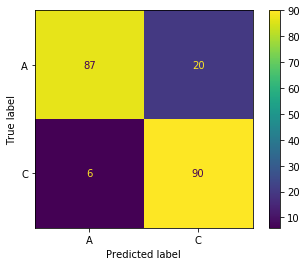

In [165]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(trained_model,X_test,y_test)

In [187]:
trained_model.predict(X_test)

array(['C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'C',
       'C', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'C', 'A',
       'C', 'C', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'A', 'A', 'A', 'C',
       'A', 'C', 'A', 'A', 'A', 'C', 'C', 'A', 'A', 'A', 'C', 'A', 'C',
       'A', 'A', 'C', 'C', 'A', 'A', 'C', 'C', 'C', 'C', 'A', 'C', 'A',
       'C', 'A', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C',
       'C', 'C', 'A', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'A',
       'C', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'C',
       'A', 'C', 'C', 'A', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'A', 'A',
       'A', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C',
       'C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'A', 'C', 'C', 'C', 'C',
       'A', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'C', 'A',
       'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'C', 'C', 'C',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'C

In [202]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
precision_recall_fscore_support(y_test, trained_model.predict(X_test))

(array([0.93548387, 0.81818182]),
 array([0.81308411, 0.9375    ]),
 array([0.87      , 0.87378641]),
 array([107,  96], dtype=int64))

In [203]:
accuracy_score(y_test,trained_model.predict(X_test))

0.8719211822660099

#### Creating a dataframe for analysis

In [174]:
manual_trasncript_data

,Call_ID,SpeakerId,Display,Lemmatized_Text
0,1-Agent4-2-INC wav,A,hello sir good morning this is alexa how may ...,hello sir good morning this be alexa how may i...
1,1-Agent4-2-INC wav,C,hi my name is sky i wanted to take a term insu...,hi my name be sky i want to take a term insura...
2,1-Agent4-2-INC wav,A,sure madam term insurance is the life insuranc...,sure madam term insurance be the life insuranc...
3,1-Agent4-2-INC wav,C,Alright and how much is the premium and how m...,alright and how much be the premium and how mu...
4,1-Agent4-2-INC wav,A,that benefit will depend on the type of the po...,that benefit will depend on the type of the po...
...,...,...,...,...
1007,78-Agent1-9-PH(Enroll) wav,A,it will get activated within say one or two wo...,it will get activate within say one or two wor...
1008,78-Agent1-9-PH(Enroll) wav,C,no i'm not talking about activation Im asking ...,no i be not talk about activation i be ask for...
1009,78-Agent1-9-PH(Enroll) wav,A,yeah thats what so if you are doing it right n...,yeah that s what so if you be do it right now ...
1010,78-Agent1-9-PH(Enroll) wav,C,okay then i will give my document,okay then i will give my document


In [179]:
manual_trasncript_data.loc[20,'Call_ID']

'10-Agent2-5-INC wav'

In [185]:
testing_df = X_test.reset_index()
testing_df["Predicted_Values"] = trained_model.predict(X_test)
testing_df['Actual_Values'] = ""
testing_df['Call_ID'] = ""
testing_df
for row in testing_df.itertuples():
    testing_df.loc[row[0],'Call_ID'] = manual_trasncript_data.loc[row[1],'Call_ID']
    testing_df.loc[row[0],'Actual_Values'] = pd.DataFrame(y_test).loc[row[1],'SpeakerId']
testing_df

,index,Lemmatized_Text,Predicted_Values,Actual_Values,Call_ID
0,897,please do not say anything i be contact with y...,C,C,94-Agent3-4-ULP(ch) wav
1,802,sure your one passport size photograph your aa...,C,A,81-Agent2-1-YS(Enroll) wav
2,384,okay thank you if i have any question i will c...,C,C,60-Agent3-8-PP wav
3,47,then what be you sit there for,C,C,45-Agent3-2-RP wav
4,106,sorry sir it vary between the company but our ...,A,A,25-Agent4-INC_converted wav
...,...,...,...,...,...
198,942,yes specifically know about the unit link plan...,C,C,90-Agent3-8-ULP(i) wav
199,812,yeah so i want to know what be the payment and...,C,C,80-Agent2-1-YS(Enquiry) wav
200,898,good afternoon hdfc life customer care this be...,A,A,93-Agent3-4-ULP(e) wav
201,221,the premium for quarterly be six thousand rupe...,C,A,39-Agent3-2-ULP wav


In [190]:
testing_df['Is_Misclassified'] = np.where(testing_df['Predicted_Values']==testing_df['Actual_Values'],0,1)

In [196]:
(testing_df[testing_df['Is_Misclassified']==1])

,index,Lemmatized_Text,Predicted_Values,Actual_Values,Call_ID,Is_Misclassified
1,802,sure your one passport size photograph your aa...,C,A,81-Agent2-1-YS(Enroll) wav,1
8,162,actually it would be refund in a ten working day,C,A,35-Agent3-INC wav,1
11,6,that will be give from the insurance company t...,C,A,1-Agent4-2-INC wav,1
27,804,definitely also the form okay,C,A,81-Agent2-1-YS(Enroll) wav,1
32,143,it will be as per the service provider,C,A,27-Agent2-3-INC_converted wav,1
35,914,what you say i be i be i have your regular thi...,A,C,92-Agent3-4-ULP(c) wav,1
40,533,and your mobile number sir,C,A,71-Agent1-2-EHI(enroll) wav,1
44,1007,it will get activate within say one or two wor...,C,A,78-Agent1-9-PH(Enroll) wav,1
48,20,fine but this be just too much work i be busy ...,A,C,10-Agent2-5-INC wav,1
65,726,be about two thousand four hundred rupee,C,A,86-Agent2-5-YSP(Enquiry) wav,1


In [193]:
testing_df[testing_df['Is_Misclassified']==1].groupby(['Call_ID']).count()

,index,Lemmatized_Text,Predicted_Values,Actual_Values,Is_Misclassified
Call_ID,,,,,
1-Agent4-2-INC wav,1,1,1,1,1
10-Agent2-5-INC wav,1,1,1,1,1
23-Agent4-INC_converted wav,1,1,1,1,1
27-Agent2-3-INC_converted wav,1,1,1,1,1
28-Agent4-INC_converted wav,1,1,1,1,1
35-Agent3-INC wav,1,1,1,1,1
39-Agent3-2-ULP wav,1,1,1,1,1
40-Agent3-2-RP-c wav,1,1,1,1,1
40-Agent3-INC wav,1,1,1,1,1
